<center>
# Geomodeling of bed properties by machine learning algorithms

<center>
## Goal

In this case it is suggested to predict **net-to-gross (NTG)** distribution across the oilfield in the interwell space via application of different machine learning algorithms.

**Target metric - root mean squared error (RMSE)**.

<center>
## Case description
In order to estimate different geological properties of an oilfield target formation we need to drill a well and evaluate beds by well logs. Recorded measurmenets can be interpreted and expert can say at which depth we have reservoir intervals. Typical example of these well logs records and corresponding intepretation is presented on the figure below.
<img src="img\log_interpretation.png">
This interpretation allows calculation of net-to-gross (NTG) property which reflects ratio of reservoir thickness to formation thickness. Higher NTG can give to us higher volumes of oil. The main problem is that drilling wells is very expensive operation and we want to have information about NTG at a certain point in space before drilling. So we use information from already drilled wells to interpolate it and make a prediction about property distribution in the interwell space in order to choose the best points for next wells.

As a data for experiments information from synthetic geological model was used. It was build on the base of description of fluvial outcrop (presented on the figure below) located at Western Siberia. It represents a complex geology which allows algorithm estimation in a difficult task.
<img src="img\Razrez.png" width = 800>

Produced synthetic geological model represents a 3D grid with 200x200m (on the figure) cells with different thickness. Each cell can be a reservoir or non-reservoir, so each point can be characterized by NTG value. This data used as ground truth for predictive models accuracy estimation.
<img src="img\3D_model.png" width = 800>

Available data contains information about 10% of points (each point represents a drilled well, in real life volume of available data can be even less than 1% of oilfield area) which can be used to train algorithm in order to predict NTG properties within interwell space.

In [13]:
# Load necessery libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
%matplotlib inline

In [14]:
#load data
data = pd.read_csv(r'data/Training_wells.csv')

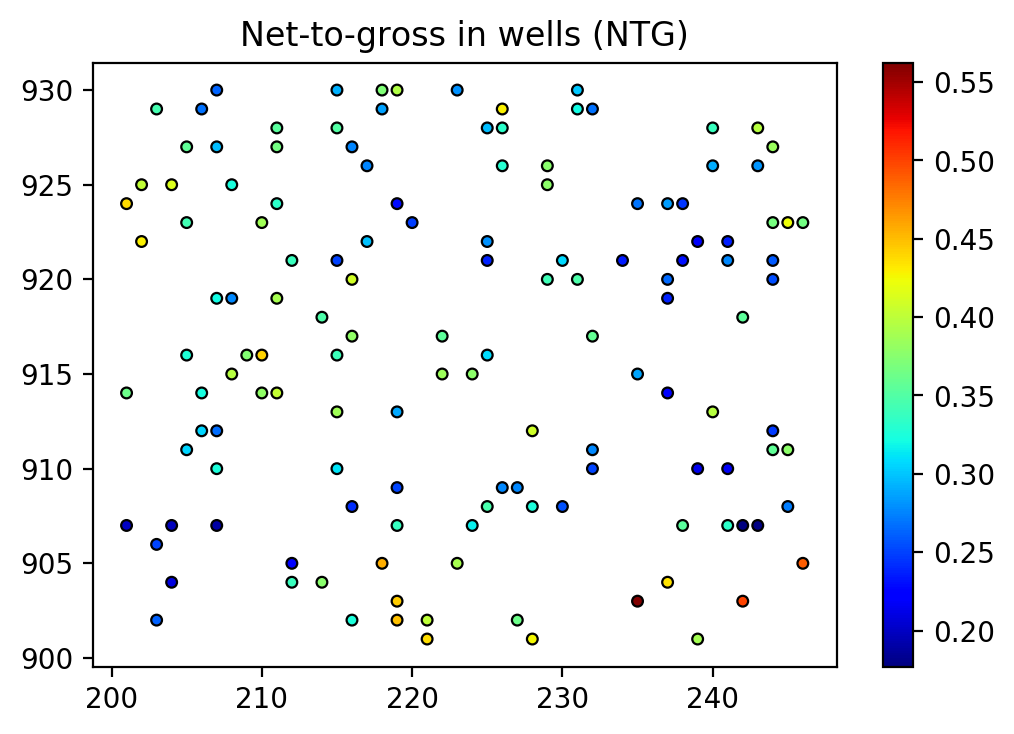

In [15]:
# Draw available data
plt.figure(dpi = 200)
plt.title('Net-to-gross in wells (NTG)')
plt.scatter(data.X, data.Y, cmap = 'jet', c = data.NTG, marker='o', lw = 0.8, edgecolors='black', s = 15)
plt.colorbar()
plt.show()

<center>
## Build feature space
    
In this baseline solution as a features information from nearest points will be used (NTG from these points and distances between them and esimation point). This is it, for each points we have just 6 features which can be used for prediction. Figure below explaints constructed feature space.
<img src="img\neighbors.png">

In [16]:
# Build feature space
# For each well information from nearest wells can be taken
# This information will be used for training and prediction
feature_set = np.empty([0, 7])
for well in data.Well.unique():
    target_point = list(map(int, well.split('-')))
    well_distance,index = cKDTree(data[['X', 'Y']]).query(target_point, k = 4)
    train = np.hstack([well_distance[1:],
                       data.loc[index[1:], 'NTG'].values,
                       data.loc[data.Well==well, 'NTG'].values])
    feature_set = np.vstack([feature_set, train])

In [17]:
# Divide data into train and test sets
Feature_data = feature_set[:, :6]
Target_data = feature_set[:, 6]
X_train, X_test, y_train, y_test = train_test_split(Feature_data,
                                                    Target_data, random_state = 17, test_size = 0.2)

In [18]:
# Create and train model with following prediction
clf = Ridge(alpha=0.2, random_state = 17)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

In [19]:
# Callculate accuracy metric
print('RMSE is equal to',np.sqrt(mean_squared_error(y_test, prediction)).round(4))

RMSE is equal to 0.0566


In [20]:
# Train model on the whole dataset
clf.fit(Feature_data, Target_data)

Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [21]:
# Build features for empty points
empty = pd.read_csv('data/Empty_part.csv')

feature_set_test = np.empty([0, 6])
for well in empty.Well.unique():
    target_point = list(map(int, well.split('-')))
    well_distance,index = cKDTree(data[['X', 'Y']]).query(target_point, k = 4)
    train = np.hstack([well_distance[1:],
                      data.loc[index[1:], 'NTG'].values])
    feature_set_test = np.vstack([feature_set_test, train])

In [22]:
# Make prediction for empty points and concatenate them with available data for drawing
empty['NTG'] = clf.predict(feature_set_test)
resulting_pd = empty.append(data)

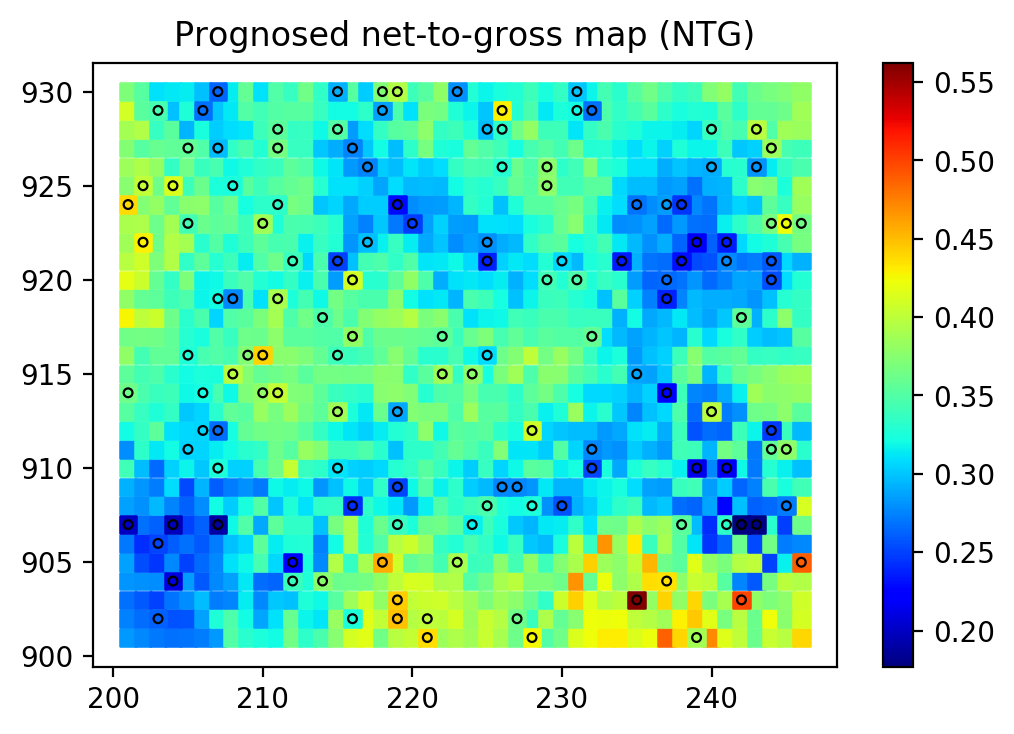

In [23]:
# Draw map
plt.figure(dpi = 200)
plt.title('Prognosed net-to-gross map (NTG)')
plt.scatter(resulting_pd.X, resulting_pd.Y, cmap = 'jet', c = resulting_pd.NTG, marker='s', lw = 0.92)
plt.colorbar()
plt.scatter(data.X, data.Y, cmap = 'jet', c = data.NTG, marker='o', lw = 0.8, edgecolors='black', s = 10)
plt.show()

In [24]:
# Upload results for solution evaluation on the hidden part of data
team_name = 'RidgeMean'
empty.to_csv('%s_prediction.csv'%team_name, index = None)